# ***`Ml models for solar flare predictions`***

> differing while focused on different properties.
focused of the graphical slope of magnetic signal observed.




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.table import Table
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

preprocessing

In [ ]:
class Preprocessing():
    def __init__(self, file_path):
        self.__raw_time, self.__raw_rate = self.__read_file(file_path)
        self.__arr_time, self.__arr_rate = self.__find_intervals()
        self.__smooth_time, self.__smooth_rate = self.__smoothen_intervals()
        self.time, self.rate = self.__interpolate()

    def __read_file(self, file_path):
        table = Table.read(file_path)
        t0 = table['TIME'][0]
        time = [int(t - t0) for t in table['TIME']]
        rate = table['RATE']
        return time, rate

    def __find_intervals(self):
        t1 = []
        r1 = []
        for i in range(len(self.__raw_time)-1):
            t1.append(self.__raw_time[i])
            r1.append(self.__raw_rate[i])
            if (self.__raw_time[i+1]-self.__raw_time[i] == 2):
                t1.append(self.__raw_time[i] + 1)
                r1.append((self.__raw_rate[i] + self.__raw_rate[i+1]) / 2)
        s = []
        e = []
        s.append(0)
        for i in range(1, len(t1)):
            if (t1[i]-t1[i-1] > 1):
                e.append(i)
                s.append(i)
        e.append(len(t1))
        t2 = []
        r2 = []
        for i in range(len(s)):
            x = []
            y = []
            for j in range(s[i], e[i]):
                x.append(t1[j])
                y.append(r1[j])
            t2.append(x)
            r2.append(y)
        return t2, r2

    def __smoothen_intervals(self):
        time = []
        rate = []
        for i in range(len(self.__arr_time)):
            x = self.__arr_time[i]
            y = self.__arr_rate[i]
            if (len(x) >= 240):
                norm = []
                norm_dp = []
                window_size = 240 * int(1 / (1 + np.exp(-1 * (len(x) - 240))))
                shift = window_size // 2
                norm.append(np.mean(y[0:window_size]))
                norm_dp.append(x[0])
                for j in range(window_size, len(y), shift):
                    temp = np.mean(y[j:j+shift])
                    norm.append(temp)
                    norm_dp.append(x[j])
                norm = np.array(norm)
                norm_dp = np.array(norm_dp)
                x_new = np.linspace(x[0], x[0]+len(x), x[0]+len(x))
                func = interp1d(norm_dp, norm, fill_value='extrapolate', kind='linear')
                y_new = func(x_new)
                time.append(x_new)
                rate.append(y_new)
        return time, rate

    def __interpolate(self):
        x = []
        y = []
        for i in range(len(self.__smooth_time)):
            for j in range(len(self.__smooth_time[i])):
                x.append(self.__smooth_time[i][j])
                y.append(self.__smooth_rate[i][j])
        x_new = np.linspace(int(x[0]), int(x[-1]-x[0]), int(x[-1]-x[0]))
        func = interp1d(x, y, fill_value='extrapolate', kind='linear')
        y_new = func(x_new)
        return x_new, y_new

## **For detection following variables were used**

Public:

time, rate: Processed time, rate

s1, p1: Starts and Peaks, basic extremas calculations

s2, p2: Pairing the starts and peaks

s3, p3: Level 2 points filtered off by slope

s4, p4: Level 3 points filtered off by closeness (determined by error in observations)

s5, p5: Level 4 points filtered off by height

e1: Ends of each flares

In [ ]:
class DetectFlares():
    def __init__(self, time, rate):
        self.time, self.rate = time, rate
        self.s1, self.p1 = self.__calc_extremas()
        self.s2, self.p2 = self.__pair_extremas()
        self.s3, self.p3 = self.__slope_thresholding()
        self.s4, self.p4 = self.__filter_close()
        self.s5, self.p5 = self.__height_thresholding()
        self.e1 = self.__detect_ends()

    def __calc_extremas(self):
        s = []
        p = []
        if (self.rate[0]<=self.rate[1]):
            s.append(0)
        for i in range(1, len(self.time)-1):
            if (self.rate[i-1]<self.rate[i]) and (self.rate[i]>self.rate[i+1]):
                p.append(i)
            elif (self.rate[i-1]>self.rate[i]) and (self.rate[i]<self.rate[i+1]):
                s.append(i)
        if (self.rate[-2]>=self.rate[-1]):
            s.append(len(self.rate)-1)
        return s, p

    def __pair_extremas(self):
        s = []
        p = []
        for i in range(len(self.p1)):
            for j in range(len(self.s1)-1):
                if (self.time[self.s1[j+1]] > self.time[self.p1[i]]):
                    s.append(self.s1[j])
                    p.append(self.p1[i])
                    break
        return s, p

    def __slope_thresholding(self):
        s = []
        p = []
        for _s, _p in zip(self.s2, self.p2):
            slope = (self.rate[_p]-self.rate[_s]) / (self.time[_p]-self.time[_s])
            if (slope > 0.014):
                s.append(_s)
                p.append(_p)
        return s, p

    def __filter_close(self):
        s = []
        p = []
        i = 0
        while (i < len(self.p3)):
            j = i+1
            while (j < len(self.p3)):
                if (self.rate[self.p3[j]]-self.rate[self.p3[i]] > 15) or (self.time[self.p3[j]]-self.time[self.p3[i]] > 1000):
                    break
                j += 1
            s.append(self.s3[i])
            p.append(self.p3[j-1])
            i = j
        return s, p

    def __height_thresholding(self):
        s = []
        p = []
        heights = np.array([(self.rate[self.p4[i]]-self.rate[self.s4[i]]) for i in range(len(self.p4))])
        avg_height = np.average(heights)
        for i in range(len(heights)):
            if (heights[i] > avg_height):
                s.append(self.s4[i])
                p.append(self.p4[i])
        return s, p

    def __detect_ends(self):
        e = []
        for i in range(len(self.p5)):
            for j in range(self.p5[i], len(self.rate)):
                if (i == len(self.p5)-1):
                    if (self.time[self.s1[-1]] < self.time[self.p5[i]]):
                        e.append(len(self.rate)-1)
                        break
                    elif (j == len(self.rate)-1):
                        e.append(len(self.rate)-1)
                if (self.rate[j] < (self.rate[self.p5[i]]+self.rate[self.s5[i]])/2):
                    e.append(j)
                    break
                if (i+1 < len(self.s5)):
                    if (self.time[j] > self.time[self.s5[i+1]]):
                        e.append(j-1)
                        break
        return e

    def plot(self):
        plt.figure(figsize=(30, 10))
        plt.title('Solar Activity')
        plt.plot(self.time, self.rate)
        plt.plot([self.time[i] for i in self.s5], [self.rate[i] for i in self.s5], 'x')
        plt.plot([self.time[i] for i in self.p5], [self.rate[i] for i in self.p5], 'o')
        plt.plot([self.time[i] for i in self.e1], [self.rate[i] for i in self.e1], 'x')
        plt.xlabel('Time (in s)')
        plt.ylabel('Count Rate')
        plt.grid()
        plt.show()

# **functions used to model sample flare**


*   linear_func: The rise of the flare
*   log_exp_func: Log of the fall of the flare

In [ ]:
def linear_func(x, m, c):
    return (m*x + c)

def log_exp_func(x, ln_a, b):
    t = -1 * b * np.sqrt(x)
    return (ln_a + t)

 **ModelFlares**
class has the following variables:

Public:

1.   time, rate: Processed time, ratetime, rate: Processed time, rate
2.   s, p, e: The observed start, peak and end of each flare
3.   background: The background i.e. the global minima of the entire data
4.  s_calc, e_calc: The calculated start and end time of each flare, post curve fitting
5.  classes: The class of each flare
6.  data: A pandas DataFrame of the above data

In [ ]:
class ModelFlares():
    def __init__(self, time, rate, start, peak, end):
        self.time = time
        self.rate = rate
        self.s = start
        self.p = peak
        self.e = end
        self.background = np.min(rate)
        self.s_calc = self.__calc_starts()
        self.e_calc = self.__calc_ends()
        self.classes = self.__classify()
        self.data = self.__generate_df()

    def __calc_starts(self):
        s_calc = []
        for i in range(len(self.s)):
            x_rise = self.time[self.s[i]:self.p[i]+1]
            y_rise = self.rate[self.s[i]:self.p[i]+1]
            popt, pcov = curve_fit(linear_func, x_rise, y_rise)
            m, c = popt
            s_calc.append(int((self.background - c) / m))
        return s_calc

    def __calc_ends(self):
        e_calc = []
        for i in range(len(self.p)):
            x_fall = self.time[self.p[i]:self.e[i]+1] - self.time[self.p[i]]
            y_fall = np.log(self.rate[self.p[i]:self.e[i]+1])
            popt, pcov = curve_fit(log_exp_func, x_fall, y_fall)
            ln_a, b = popt
            end_time = np.square((np.log(self.background) - ln_a) / (-1 * b)) + self.p[i]
            e_calc.append(int(end_time))
        return e_calc

    def __classify(self):
        classes = []
        for i in range(len(self.p)):
            peak_intensity = self.rate[self.p[i]]
            val = np.log10(peak_intensity / 25)
            _val = str(int(val*100) / 10)[-3:]
            c = ""
            if int(val) < 1:
                c = "A" + _val
            elif int(val) == 1:
                c = "B" + _val
            elif int(val) == 2:
                c = "C" + _val
            elif int(val) == 3:
                c = "M" + _val
            elif int(val) > 3:
                c = "X" + _val
            classes.append(c)
        return classes

    def __generate_df(self):
        start_intensities = [self.rate[i] for i in self.s]
        peak_intensities = [self.rate[i] for i in self.p]
        df = pd.DataFrame([self.s, self.p, self.e, self.s_calc, self.e_calc, start_intensities, peak_intensities, self.classes])
        df = df.T
        df.columns = ['Observed Start Time', 'Peak Time', 'Observed End Time', 'Calculated Start TIme', 'Calculated End Time', 'Pre-Flare Count Rate', 'Total Count Rate', 'Class']
        return df

# ***visualizing dataset***

In [ ]:
path_to_lc = '/content/ch2_xsm_20201111_v1_level2.lc'
data=Preprocessing(path_to_lc)

# ***flare detection and plotting***

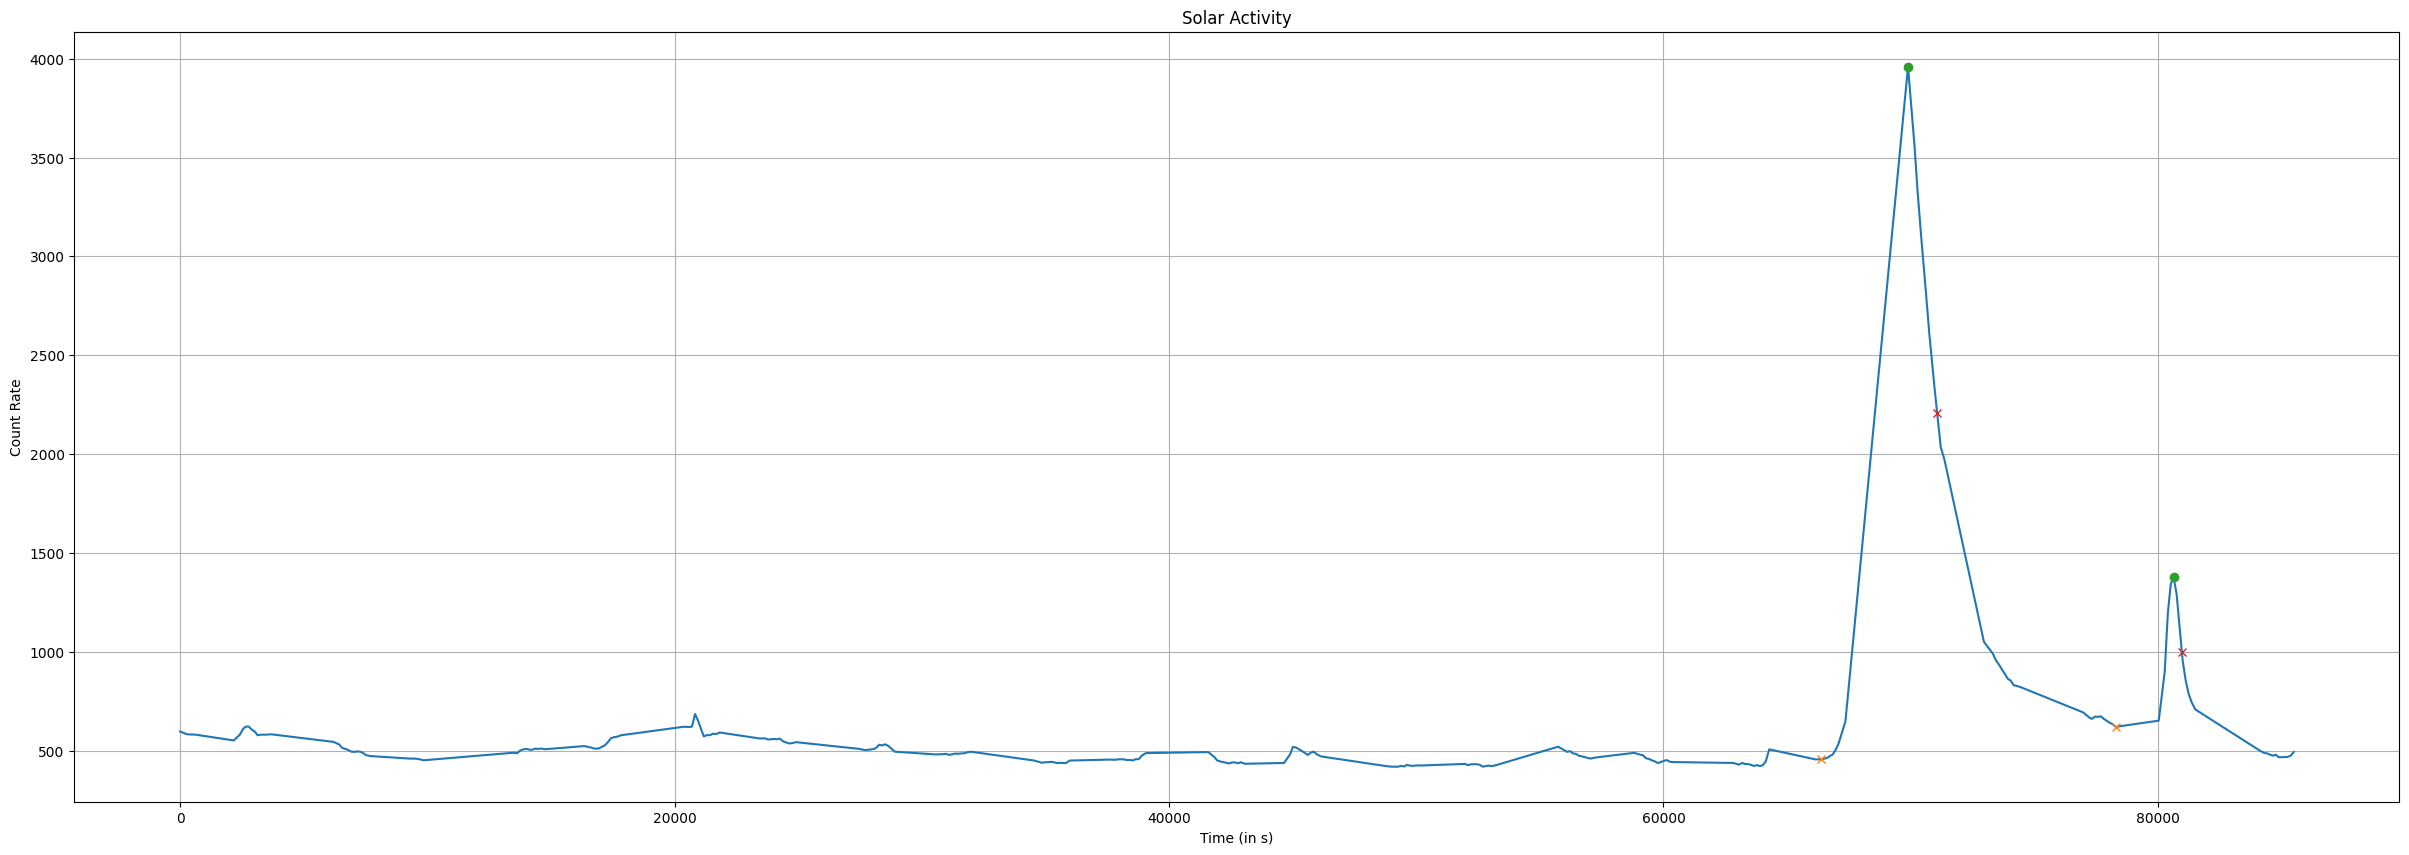

,Observed Start Time,Peak Time,Observed End Time,Calculated Start TIme,Calculated End Time,Pre-Flare Count Rate,Total Count Rate,Class
0,66359,69889,71068,66878,83845,456.201477,3959.178028,C1.9
1,78286,80629,80964,78054,84689,620.164786,1378.309307,B7.4


In [ ]:
identified = DetectFlares(data.time, data.rate)
identified.plot()

model = ModelFlares(data.time, data.rate, identified.s5, identified.p5, identified.e1)
model.data